In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report


In [5]:
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
import plotly.express as px
from collections import defaultdict
import time
#!pip install xgboost
from xgboost import XGBClassifier

In [6]:
# def clean_party_create_infer():
#     corrected_data = pd.read_csv("data/data_500k.csv").sample(20000)
   
    
#     #set index to 'RECORD_ID' to be able to match records with 500K dataset
#     corrected_data.set_index('RECORD_ID', inplace=True)
   
#     #Replace blanks and spaces with NaN
#     corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#     # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
#     corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

#     # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
#     states_to_update = ['DC', 'LA', 'RI']
#     corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'

#     # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
#     corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'
    
# #     print("N's after corrections")
# #     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['N'])]))
    
# #     print("U's after corrections")
# #     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['U'])]))
    
# #     print("inferred Rs:")
# #     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))

# #     print("inferred Ds:")
# #     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))


   
#     print("new inferred Rs:")
#     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['S'])]))

#     print("new inferred Ds:")
#     print(len(corrected_data.loc[corrected_data['PARTY_CODE'].isin(['E'])]))
          

#     corrected_data['INFER_PARTY'] = np.nan
# #     corrected_data.loc[(corrected_data['PRFL_BORDER_SECURITY'] == 'Y') , 'INFER_PARTY'] = 'R'
# #     corrected_data.loc[(corrected_data['PRFL_IMMIGRATION_REFORM'] == 'Y') , 'INFER_PARTY'] = 'D'           
# #     corrected_data.loc[(corrected_data['PRFL_LIBERAL_NEWS'] == 'Y') , 'INFER_PARTY'] = 'D'
    
    
# #            # Create party_mapping using defaultdict.Lambda sets default (all other non-D and non-R party registrations to NaN.
# #     infer_party_mapping = defaultdict(lambda: float('nan'))
# #     infer_party_mapping.update({
# #         'D': 'D',  # Registered Democrats are mapped to Democrat
# # #        'E': 'D',  # E (Inferred Democrats) are mapped to Democrat
# #         'R': 'R',  # Registered Republicans are mapped to Republican 
# #  #       'S': 'R',
# # #        'L' :'R' # S (Inferred Republicans) are mapped to Republican
# #     })
# #     # Map PARTY_CODE to INFER_PARTY
# #     corrected_data['INFER_PARTY'] = corrected_data['PARTY_CODE'].map(infer_party_mapping)

# #     # Define the mapping for PARTY_CODE modifications
# #     party_code_mapping = {
# #         'E': float('nan'),
# #         'S': float('nan'),
# #         'U': float('nan'),
# #         'A': 'O',
# #         'B': 'O',
# #         'C': 'O',
# #         'F': 'O',
# #         'G': 'O',
# #         'H': 'O',
# #         'I': 'O',
# #         'J': 'O',
# #         'K': 'O',
# #       #  'L': 'L',
# #         'P': 'O',
# #         'Q': 'O',
# #         'T': 'O',
# #         'V': 'O',
# #         'W': 'O',
# #         'Y': 'O',
# #         'Z': 'O'
# #     }
# #     # Apply the mapping to the PARTY_CODE column
# #     corrected_data['PARTY_CODE'] = corrected_data['PARTY_CODE'].replace(party_code_mapping)

#     print("Final PARTY_CODE values:")
#     print(corrected_data['PARTY_CODE'].unique())
#     print('Final INFER_PARTY values:')
#     print(corrected_data['INFER_PARTY'].unique())
#     print('INFER_PARTY Ds and Rs:')
#     print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
#     print('INFER_PARTY NaNs:')
#     print(corrected_data['INFER_PARTY'].isna().sum())
    
    
    
# #     voter_columns = [col for col in corrected_data.columns if col.startswith("VTR")]

# #     #Create column with total number of votes in voter_columns per row
# #     corrected_data['VTR_TOTAL_VOTES'] = corrected_data[voter_columns].notnull().sum(axis=1)

# #     #Sum Democrat and Republican totals
# #     corrected_data['VTR_TOTAL_DVOTES'] = corrected_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
# #     corrected_data['VTR_TOTAL_RVOTES'] = corrected_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)

# #     #Create conditions that evaluate whether someone has cast at least two more votes for Democrats or Republicans: 
# #     conditions = [
# #         corrected_data['VTR_TOTAL_DVOTES'] - corrected_data['VTR_TOTAL_RVOTES'] >= 2,
# #         corrected_data['VTR_TOTAL_RVOTES'] - corrected_data['VTR_TOTAL_DVOTES'] >= 2
# #     ]

# #     choices = ['D', 'R']

# #     corrected_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
# #     corrected_data['VTR_INFER_PARTY'].replace('nan', np.nan, inplace=True)

# #     # Assign a 'D' or an 'R' to INFER_PARTY if either condition is true:
# #     corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'D') , 'INFER_PARTY'] = 'D'
# #     corrected_data.loc[(corrected_data['VTR_INFER_PARTY'] == 'R') , 'INFER_PARTY'] = 'R'    
# #     corrected_data.drop(columns=["VTR_INFER_PARTY", "VTR_TOTAL_DVOTES", "VTR_TOTAL_RVOTES"], inplace=True)

#     # If anyone has voted Dem or Repub in a more recent election, change their INFER_PARTY label to that party
#     columns_to_check = ['VTR_PPP16', 'VTR_GEN16','VTR_PRI18','VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22',  ]
#     democrat_values = ['D', 'M', 'Z']
#     republican_values = ['R', 'P', 'X']

#     # Loop through the columns and set the 'INFER_PARTY' value based on the mappings
#     for column in columns_to_check:
#         corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
#         corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'
        
        
    
# #     'VTR_GEN00', 'VTR_GEN01', 'VTR_GEN02', 'VTR_GEN03', 'VTR_GEN04', 'VTR_GEN05', 'VTR_GEN06', 'VTR_GEN07', 'VTR_GEN08', 'VTR_GEN09', 'VTR_GEN10', 'VTR_GEN11', 'VTR_GEN12', 
# #     'VTR_GEN13', 'VTR_GEN14', 'VTR_GEN15', 'VTR_GEN16', 'VTR_GEN17', 'VTR_GEN18', 'VTR_GEN19', 'VTR_GEN20', 'VTR_GEN21', 'VTR_GEN22', 'VTR_OTH00', 'VTR_OTH01', 'VTR_OTH02', 
# #     'VTR_OTH03', 'VTR_OTH04', 'VTR_OTH05', 'VTR_OTH06', 'VTR_OTH07', 'VTR_OTH08', 'VTR_OTH09', 'VTR_OTH10', 'VTR_OTH11', 'VTR_OTH12', 'VTR_OTH13', 'VTR_OTH14', 'VTR_OTH15', 
# #     'VTR_OTH16', 'VTR_OTH17', 'VTR_OTH18', 'VTR_OTH19', 'VTR_OTH20', 'VTR_OTH21', 'VTR_OTH22', 'VTR_PPP00', 'VTR_PPP04', 'VTR_PPP08', 'VTR_PPP12', 'VTR_PPP16', 'VTR_PPP20', 
# #     'VTR_PRI00', 'VTR_PRI01', 'VTR_PRI02', 'VTR_PRI03', 'VTR_PRI04', 'VTR_PRI05', 'VTR_PRI06', 'VTR_PRI07', 'VTR_PRI08', 'VTR_PRI09', 'VTR_PRI10', 'VTR_PRI11', 'VTR_PRI12', 
# #     'VTR_PRI13', 'VTR_PRI14', 'VTR_PRI15', 'VTR_PRI16', 'VTR_PRI17', 'VTR_PRI18', 'VTR_PRI19', 'VTR_PRI20', 'VTR_PRI21', 'VTR_PRI22',       
 
#     filtered_large_data = large_data.loc[~large_data.index.isin(engineered_survey.index)]
#     filtered_large_data

#     print('Final INFER_PARTY Ds and Rs:')
#     print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
#     print('Final INFER_PARTY NaNs:')
#     print(corrected_data['INFER_PARTY'].isna().sum())
    
#     return corrected_data
# engineered_data = clean_party_create_infer()

In [892]:

def infer_party(corrected_data):

    #set index to 'RECORD_ID' to be able to match records with 500K dataset
    corrected_data.set_index('RECORD_ID', inplace=True)

    #Replace blanks and spaces with NaN
    corrected_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'SD'
    corrected_data.loc[(corrected_data['STATE'] == 'SD') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    # Update the 'U' values in PARTY_CODE to 'N' for rows where STATE is in ['DC', 'LA', 'RI']
    states_to_update = ['DC', 'LA', 'RI']
    corrected_data.loc[(corrected_data['STATE'].isin(states_to_update)) & (corrected_data['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'

    # Update the 'I' values in PARTY_CODE to 'N' for rows where STATE is 'OK'
    corrected_data.loc[(corrected_data['STATE'] == 'OK') & (corrected_data['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

    corrected_data['INFER_PARTY'] = np.nan

    # If anyone has voted Dem or Repub in a more recent election, change their INFER_PARTY label to that party
    columns_to_check = ['VTR_PPP16', 'VTR_GEN16','VTR_PRI18','VTR_GEN18', 'VTR_PRI20', 'VTR_PPP20', 'VTR_GEN20', 'VTR_PRI22', 'VTR_GEN22',  ]
    democrat_values = ['D', 'M', 'Z']
    republican_values = ['R', 'P', 'X']

    # Loop through the columns and set the 'INFER_PARTY' value based on the mappings
    for column in columns_to_check:
        corrected_data.loc[corrected_data[column].isin(democrat_values), 'INFER_PARTY'] = 'D'
        corrected_data.loc[corrected_data[column].isin(republican_values), 'INFER_PARTY'] = 'R'


    print('Final INFER_PARTY Ds and Rs:')
    print(len(corrected_data.loc[corrected_data['INFER_PARTY'].isin(['D', 'R'])]))
    print('Final INFER_PARTY NaNs:')
    print(corrected_data['INFER_PARTY'].isna().sum())
    
    return corrected_data

     
def additional_cleaning(data):
    
    # Convert mixed type columns to either all numeric or all string representations
    data['CNS_MEDINC'] = data['CNS_MEDINC'].astype('Int64')
    data['YEARBUILT'] = data['YEARBUILT'].astype('Int64')
    data['VOTER_CNT'] = data['VOTER_CNT'].str.strip().astype('Int64')
    data['HH_SIZE'] = data['HH_SIZE'].str.strip().astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].astype(str)
    data['GENDER_MIX'] = data['GENDER_MIX'].astype(str)
    data['AGE']=data['AGE'].astype('Int64')
    data['CRD_RANGE']=data['CRD_RANGE'].astype('Int64')
    data['PERSONS_HH'] = data['PERSONS_HH'].astype('Int64')
    data['NUMCHILD'] = data['NUMCHILD'].astype('Int64')
    data['LENGTH_RES'] = data['LENGTH_RES'].astype('Int64')
    
    
    # Mapping for INCOMESTHH
    income_map = {
        'A': 5000, 'B': 12500, 'C': 17500, 'D': 22500, 'E': 27500,
        'F': 32500, 'G': 37500, 'H': 42500, 'I': 47500, 'J': 52500,
        'K': 57500, 'L': 62500, 'M': 70000, 'N': 87500, 'O': 125000,
        'P': 162500, 'Q': 187500, 'R': 225000, 'S': 300000  # Since it's 250,000+, this is a simplification
    }

    # Mapping for NETWORTH
    networth_map = {
        'A': 0, 'B': 2500, 'C': 7500, 'D': 17500, 'E': 37500,
        'F': 75000, 'G': 175000, 'H': 375000, 'I': 500000  # Since it's >499,999, this is a simplification
    }

    # Mapping for CREDRATE
    cred_rate_map = {
        'A': 800, 'B': 775, 'C': 725, 'D': 675, 'E': 625,
        'F': 575, 'G': 525, 'H': 499  # Assuming under 499 to be 499 for simplification
    }

    # Mapping for VOTER_TRLR
    voter_trlr_map = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G':16
    }

    # Define education mapping
    education_mapping = {
        'A': 0,
        'D': 1,
        'B': 2,
        'C': 3
    }
    # Define homemktval mapping
    homemktval_mapping = {
        'A': 1,   # 1,000 - $24,999
        'B': 2,   # $25,000 - $49,999
        'C': 3,   # $50,000 - $74,999
        'D': 4,   # $75,000 - $99,999
        'E': 5,   # $100,000 - $124,999
        'F': 6,   # $125,000 - $149,999
        'G': 7,   # $150,000 - $174,999
        'H': 8,   # $175,000 - $199,999
        'I': 9,   # $200,000 - $224,999
        'J': 10,  # $225,000 - $249,999
        'K': 11,  # $250,000 - $274,999
        'L': 12,  # $275,000 - $299,999
        'M': 13,  # $300,000 - $349,999
        'N': 14,  # $350,000 - $399,999
        'O': 15,  # $400,000 - $449,999
        'P': 16,  # $450,000 - $499,999
        'Q': 17,  # $500,000 - $749,999
        'R': 18,  # $750,000 - $999,999
        'S': 19   # $1,000,000 Plus
    }
    # Applying the mappings
    data['INCOMESTHH'] = data['INCOMESTHH'].replace(income_map).astype('Int64')
    data['NETWORTH'] = data['NETWORTH'].replace(networth_map).astype('Int64')
    data['CREDRATE'] = data['CREDRATE'].replace(cred_rate_map).astype('Int64')
    data['VOTER_TRLR'] = data['VOTER_TRLR'].replace(voter_trlr_map).astype('Int64')
    data['EDUCATION'] = data['EDUCATION'].replace(education_mapping).astype('Int64')
    data['HOMEMKTVAL'] = data['HOMEMKTVAL'].replace(homemktval_mapping).astype('Int64')
  
    #Turning the PRES_DIFF columns into numerical variables:
    tod_pres_diff_cols = [col for col in data.columns if col.startswith('TOD_PRES_DIFF')]

    replacements = {
        '78DO': '78D',
        '17RO': '17R',
        'TIE': 0
    }
    for key, value in replacements.items():
        data[tod_pres_diff_cols] = data[tod_pres_diff_cols].replace(key, value)

    for col in tod_pres_diff_cols:
        # Skip if the column has already been converted 
        if data[col].dtype != 'object':
            continue

        # Strip any whitespace
        stripped_col = data[col].str.strip()

        # Extract numerical margin and party character
        num = stripped_col.str[:-1].replace('', np.nan).astype(float)

        party_char = stripped_col.str[-1]

        # Create the signed margin column
        signed_margin = num.where(party_char == 'D', -num)  # Positive for D, negative for R
        data[col] = signed_margin

#         # Define bin edges and labels
#         bin_edges = [-float('inf'), -50, -25, -10, -5, 0, 5, 10, 25, 50, float('inf')]
#         labels = [-7, -5, -3, -2, -1, 1, 2, 3, 5, 7]

#         # Apply the binning for each 'TOD_PRES_DIFF' column
#         for col in tod_pres_diff_cols:
#             engineered_data[col] = pd.cut(engineered_data[col], bins=bin_edges, labels=labels, ordered=False)


        # # Plotting the distribution of the 'TOD_PRES_DIFF_2016' column as an example
        # plt.figure(figsize=(10, 6))
        # engineered_data['TOD_PRES_DIFF_2016'].hist(bins=50, edgecolor='black', alpha=0.7)
        # plt.title('Distribution of TOD_PRES_DIFF_2016')
        # plt.xlabel('Margin')
        # plt.ylabel('Frequency')
        # plt.grid(False)
        # plt.show() 
        
#         #Data engineering features
#         epsilon = 1e-10  # a small constant to prevent division by zero

#         data['interaction_div_2020'] = data['CNSUS_PCTW'] / (data['TOD_PRES_R_2020_PREC'] + epsilon)

#         data['interaction_div_2016'] = data['CNSUS_PCTW'] / (data['TOD_PRES_R_2016_PREC'] + epsilon)

#         # Delta interaction term
#         data['interaction_mult_delta'] = (data['TOD_PRES_R_2020_PREC'] - data['TOD_PRES_R_2016_PREC']) * data['CNSUS_PCTW']

#         # Interaction terms for 2020 with respect to Democratic turnout
#         data['interaction_div_D_2020'] = data['CNSUS_PCTB'] / (data['TOD_PRES_D_2020_PREC'] + epsilon)

#         data['interaction_div_D_2016'] = data['CNSUS_PCTB'] / (data['TOD_PRES_D_2016_PREC'] + epsilon)

#         # Delta interaction term for Democratic turnout
#         data['interaction_mult_D_delta'] = (data['TOD_PRES_D_2020_PREC'] - data['TOD_PRES_D_2016_PREC']) * data['CNSUS_PCTB']


    
    # Drop columns that create categorical variables that are only unique within states but not nation-wide:
    cols_to_remove = ['CONG_DIST','CENSUS_ST', 'COUNTY_ST', 'ST_LO_HOUS', 'ST_UP_HOUS', 'AI_COUNTY_NAME']
    
    # Drop the identified columns
    data = data.drop(columns=cols_to_remove)
        
    return data       
        
        


In [893]:
    
full_data = pd.read_csv("data/data_500k.csv")
survey_data = pd.read_csv('data/surveydata.csv')


In [894]:
# Convert the RECORD_ID columns of both DataFrames to sets
record_ids_survey = set(survey_data['RECORD_ID'])
record_ids_full = set(full_data['RECORD_ID'])

# Find the difference between the two sets
missing_ids = record_ids_survey - record_ids_full

print(f"Number of RECORD_IDs in survey_data that don't have a match in full_data: {len(missing_ids)}")

Number of RECORD_IDs in survey_data that don't have a match in full_data: 363


In [895]:
survey_data = infer_party(survey_data)
survey_data = additional_cleaning(survey_data)

Final INFER_PARTY Ds and Rs:
574
Final INFER_PARTY NaNs:
986


In [896]:
full_data = infer_party(full_data)
full_data = additional_cleaning(full_data)



Final INFER_PARTY Ds and Rs:
112691
Final INFER_PARTY NaNs:
387309


In [897]:
#Remove all the rows that are in the survey dataset from the 500K dataset to be sure the model is seeing those rows for the first time

full_data = full_data.loc[~full_data.index.isin(survey_data.index)]

print(len(full_data))
print(len(survey_data))

498803
1560


In [1675]:
large_data = full_data.copy()

In [1676]:
large_data

,ADD_TYPE,AFAMPROFLS,AGE,AIRCOND,APP_CHILD,APP_MENBIG,APP_TODDLR,APP_WOMEN,APP_WOMPET,APP_WOMPLS,...,WORKWOMAN,YEARBUILT,ZIP,INFER_PARTY,interaction_div_2020,interaction_div_2016,interaction_mult_delta,interaction_div_D_2020,interaction_div_D_2016,interaction_mult_D_delta
RECORD_ID,,,,,,,,,,,,,,,,,,,,,
403390,S,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99705,NaN,0.914355,0.928793,84.705882,0.000000,0.000000,0.000000
62285,H,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99506,NaN,0.773994,0.744786,-113.684210,0.084890,0.110571,18.947369
331355,NaN,NaN,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206320,H,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99567,NaN,1.047534,0.999232,-221.909549,0.000000,0.000000,0.000000
188078,S,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,1985,99801,NaN,1.806932,1.799041,-16.479218,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349635,H,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,31204,NaN,0.643382,0.764415,14.669117,1.032289,1.014772,-134.558823
420654,S,NaN,50,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2003,30263,NaN,1.266285,1.222340,-256.764705,0.000000,0.000000,0.000000
131262,S,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,30013,NaN,1.041124,0.804505,-127.433628,0.811798,0.892185,454.184579


In [1734]:


features = [
    'CHRISTFAM',
    'CRD_RANGE',
    'CREDRATE',
    'ETHNIC_INFER',
    'ETHNICCODE',
    'ETHNICGRP',
    'FUND_POLIT',
    'INCOMESTHH',
    'LENGTH_RES',
    'NETWORTH',
    'NUMCHILD',
    'PRFL_POLITICAL_IDEOLOGY',
    'PRFL_TRUMP_SUPPORT',
    'RELIGION',
    'STATUS',

    'AGE',
    'AUTOWORK',
    'CNS_MEDINC',
    'COUNTY_TYPE',    
    'EXER_GROUP',
    'GENDER_MIX',
    'HH_SIZE',
    'HOMEMKTVAL',
    'OCCUPATION',
    'PERSONS_HH',
    'PETS',
    'PRFL_ANML_RIGHTS',
    'PRFL_INSURANCE',
    'PRFL_TAXES',
    'SEX',
    'YEARBUILT',
    'INFER_PARTY',
    'TOD_PRES_DIFF_2016_PREC', 
    'TOD_PRES_DIFF_2020_PREC',
    'PRFL_BORDER_SECURITY',
    'PRFL_IMMIGRATION_REFORM',
    'PRFL_LIBERAL_NEWS',
]

large_data=large_data[features]


In [1710]:
large_data

,CHRISTFAM,CRD_RANGE,CREDRATE,ETHNIC_INFER,ETHNICCODE,ETHNICGRP,FUND_POLIT,INCOMESTHH,LENGTH_RES,NETWORTH,...,PRFL_INSURANCE,PRFL_TAXES,SEX,YEARBUILT,INFER_PARTY,TOD_PRES_DIFF_2016_PREC,TOD_PRES_DIFF_2020_PREC,PRFL_BORDER_SECURITY,PRFL_IMMIGRATION_REFORM,PRFL_LIBERAL_NEWS
RECORD_ID,,,,,,,,,,,,,,,,,,,,,
403390,NaN,<NA>,<NA>,C,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,NaN,NaN,M,<NA>,NaN,-60.0,-58.0,NaN,Y,Y
62285,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,NaN,NaN,M,<NA>,NaN,-40.0,-30.0,NaN,NaN,NaN
331355,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,NaN,NaN,M,<NA>,NaN,NaN,NaN,NaN,Y,Y
206320,NaN,5,725,C,T5,W,1,12500,15,0,...,NaN,Y,F,<NA>,NaN,-46.0,-37.0,Y,NaN,NaN
188078,Y,7,725,C,T6,W,1,300000,15,500000,...,NaN,Y,F,1985,NaN,-1.0,5.0,Y,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349635,NaN,<NA>,<NA>,B,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,Y,NaN,F,<NA>,NaN,78.0,75.0,NaN,NaN,NaN
420654,NaN,<NA>,775,NaN,N2,W,NaN,187500,1,500000,...,Y,NaN,M,2003,NaN,-59.0,-52.0,NaN,NaN,NaN
131262,NaN,<NA>,<NA>,H,HM,Y,NaN,37500,1,0,...,Y,NaN,F,<NA>,NaN,45.0,58.0,NaN,Y,NaN


In [1678]:
# Calculate the percentage of missing data for each column
missing_data_percentage = large_data.isnull().mean() * 100

# Identify columns with more than 90% missing data
cols_to_remove = missing_data_percentage[missing_data_percentage > 85].index.tolist()
print(cols_to_remove)

# # Drop the identified columns
# large_data = large_data.drop(columns=cols_to_remove)


# large_data.columns.to_list()

['CHRISTFAM', 'PRFL_TRUMP_SUPPORT']


In [1679]:
#74 83/69

# features = [
#     'CHRISTFAM',
#     'CRD_RANGE',
#     'CREDRATE',
#     'ETHNIC_INFER',
#     'ETHNICCODE',
#     'ETHNICGRP',
#     'FUND_POLIT',
#     'INCOMESTHH',
#     'LENGTH_RES',
#     'NETWORTH',
#     'NUMCHILD',
#     'PRFL_POLITICAL_IDEOLOGY',
#     'PRFL_TRUMP_SUPPORT',
#     'RELIGION',
#     'STATUS',

#     'AGE',
#     'AUTOWORK',
#     'CNS_MEDINC',
#     'COUNTY_TYPE',    
#     'EXER_GROUP',
#     'GENDER_MIX',
#     'HH_SIZE',
#     'HOMEMKTVAL',
#     'OCCUPATION',
#     'PERSONS_HH',
#     'PETS',
#     'PRFL_ANML_RIGHTS',
#     'PRFL_INSURANCE',
#     'PRFL_TAXES',
#     'SEX',
#     'YEARBUILT',
#     'INFER_PARTY',
#     'TOD_PRES_DIFF_2016_PREC', 
#     'TOD_PRES_DIFF_2020_PREC',
#     'PRFL_BORDER_SECURITY',
#     'PRFL_IMMIGRATION_REFORM',
#     'PRFL_LIBERAL_NEWS',
# ]


#73-74 70/80

# features_to_use = [
#  'AGE',
#  'AIRCOND',
#  'AUTOWORK',
#  'CNS_MEDINC',  
#  'COUNTY_TYPE',
#  'CREDRATE',    
#  'EXER_GROUP',
#  'GARDENER',
#  'GENDER_MIX',
#  'HH_SIZE',
#  'HOMEMKTVAL',
#  'INCOMESTHH',
#  'NETWORTH',
#  'NUMCHILD',
#  'OCCUPATION',
#  'PERSONS_HH',
#  'PETS',
#  'PRFL_ANML_RIGHTS',
#  'PRFL_INSURANCE',
#  'PRFL_TAXES',
#  'RD_GEN',
#  'RELIGION',
#  'SEX',
#  'YEARBUILT',
#  'INFER_PARTY',
#     'TOD_PRES_DIFF_2016',
#     'TOD_PRES_DIFF_2016_PREC', 
#     'TOD_PRES_DIFF_2020_PREC',    
#     'PRFL_BORDER_SECURITY',
#     'PRFL_IMMIGRATION_REFORM',
#     'PRFL_LIBERAL_NEWS',



#72 82/66
# features = [
#  'AIRCOND',
#  'CHRISTFAM',
#  'CRD_RANGE',
#  'CREDRATE',
#  'ETHNIC_INFER',
#  'ETHNICCODE',
#  'ETHNICGRP',
#  'FUND_POLIT',
#  'INCOMESTHH',
#  'LENGTH_RES',
#  'NETWORTH',
#  'NUMCHILD',
#  'OCCDETAIL',
#  'PRFL_POLITICAL_IDEOLOGY',
#  'PRFL_TRUMP_SUPPORT',
#  'RELIGION',
#  'STATE',
#  'STATUS',
#  'VOTER_TRLR',
#  'INFER_PARTY',
# ]





### GBM

In [1680]:

# # drop target NaN values
# filtered_data = large_data.dropna(subset=['INFER_PARTY'])
# print(len(filtered_data))
# # Create the binary target variable
# filtered_data['target'] = filtered_data['INFER_PARTY']

# # Split the data into training (80%) and testing (20%) sets
# X = filtered_data.drop(columns=['target', 'INFER_PARTY'])  
# y = filtered_data['target']  
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Identify and convert categorical columns to string type
# categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
# print(categorical_cols)



# X_train[categorical_cols] = X_train[categorical_cols].astype(str)
# X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# # Identify numerical columns
# numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
# print(numerical_cols)


# # Preprocessing for Categorical Data Only
# categorical_transformer = Pipeline(steps=[
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])
# # Preprocessing for Numerical Data
# numerical_transformer = SimpleImputer(strategy='mean')  # Impute with the mean for numerical columns

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, categorical_cols),
#         ('num', numerical_transformer, numerical_cols)
#     ])


# X_train_preprocessed = preprocessor.fit_transform(X_train)
# X_test_preprocessed = preprocessor.transform(X_test)

# # GBM Classifier
# gbm_classifier = GradientBoostingClassifier(random_state=42)
# gbm_classifier.fit(X_train_preprocessed, y_train)

# # Predictions and Evaluation
# y_pred = gbm_classifier.predict(X_test_preprocessed)

# accuracy_after_filtering = accuracy_score(y_test, y_pred)
# classification_rep_after_filtering = classification_report(y_test, y_pred)

# print(accuracy_after_filtering)
# print(classification_rep_after_filtering)



# # pipeline = Pipeline([
# #     ('preprocessor', preprocessor),
# #     ('classifier', GradientBoostingClassifier(random_state=42))
# # ])

# # scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')  # Here, we're using accuracy as the metric


# # print("Accuracy scores for the 5 folds: ", scores)
# # print("Mean cross-validation score: ", scores.mean())

112283
['CHRISTFAM', 'ETHNIC_INFER', 'ETHNICCODE', 'ETHNICGRP', 'FUND_POLIT', 'PRFL_POLITICAL_IDEOLOGY', 'PRFL_TRUMP_SUPPORT', 'RELIGION', 'STATUS', 'AUTOWORK', 'COUNTY_TYPE', 'EXER_GROUP', 'GENDER_MIX', 'OCCUPATION', 'PETS', 'PRFL_ANML_RIGHTS', 'PRFL_INSURANCE', 'PRFL_TAXES', 'SEX', 'PRFL_BORDER_SECURITY', 'PRFL_IMMIGRATION_REFORM', 'PRFL_LIBERAL_NEWS']
['CRD_RANGE', 'CREDRATE', 'INCOMESTHH', 'LENGTH_RES', 'NETWORTH', 'NUMCHILD', 'AGE', 'CNS_MEDINC', 'HH_SIZE', 'HOMEMKTVAL', 'PERSONS_HH', 'YEARBUILT', 'TOD_PRES_DIFF_2016_PREC', 'TOD_PRES_DIFF_2020_PREC']
0.9464309569399296
              precision    recall  f1-score   support

           D       0.94      0.95      0.95     11663
           R       0.95      0.94      0.94     10794

    accuracy                           0.95     22457
   macro avg       0.95      0.95      0.95     22457
weighted avg       0.95      0.95      0.95     22457



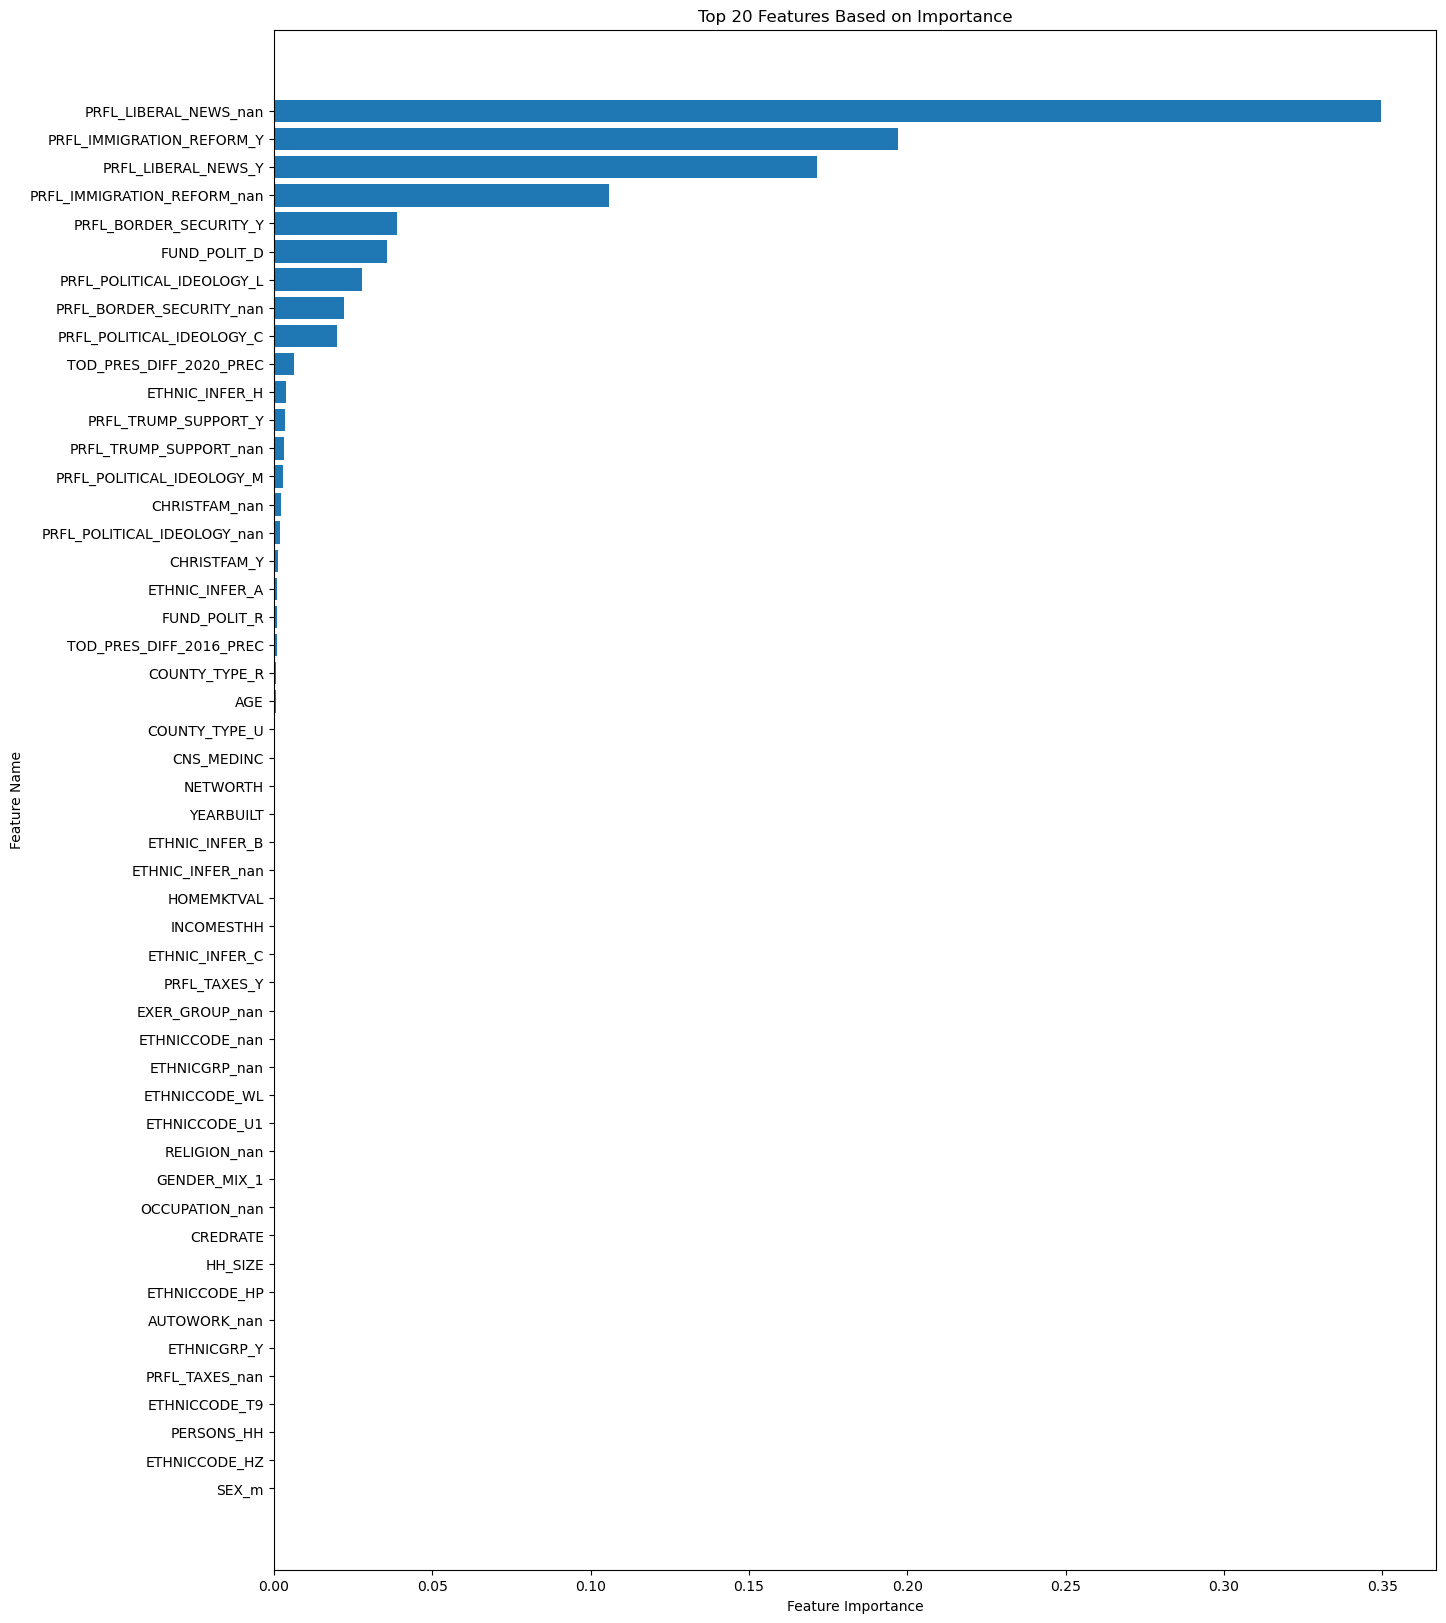

In [1733]:
# Get feature importances
feature_importances = gbm_classifier.feature_importances_

# Get the column names for one-hot encoded categorical columns
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
feature_names = np.concatenate([cat_feature_names, numerical_cols])

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:50]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(15, 20))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()

In [1682]:
# # Get the one-hot encoder and its feature names
# encoder = preprocessor.named_transformers_['cat']['encoder']
# encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# # Combine one-hot-encoded feature names and numerical column names
# all_feature_names = np.concatenate([encoded_feature_names, numerical_cols])

# # Create a dictionary to store original feature importances
# original_feature_importances = dict.fromkeys(X.columns, 0)

# for idx, feature_name in enumerate(all_feature_names):
#     for original_feature in X.columns:
#         if original_feature in feature_name:

#             original_feature_importances[original_feature] += feature_importances[idx]
#             break

# # Sort the features based on importance
# sorted_features = sorted(original_feature_importances.items(), key=lambda x: x[1])

# # Get the top 20 least useful features
# least_useful_features = sorted_features[:20]

# print(least_useful_features)


[('CRD_RANGE', 0.0), ('NUMCHILD', 0.0), ('PETS', 0.0), ('PRFL_ANML_RIGHTS', 0.0), ('PRFL_INSURANCE', 0.0), ('STATUS', 9.527389795841679e-06), ('LENGTH_RES', 9.78739244259993e-06), ('PERSONS_HH', 1.3178595563637926e-05), ('AUTOWORK', 1.6904344828276115e-05), ('HH_SIZE', 2.1098444041622262e-05), ('SEX', 2.120329939197043e-05), ('CREDRATE', 2.2080742192074033e-05), ('GENDER_MIX', 2.3955928652395427e-05), ('RELIGION', 2.9696669295525575e-05), ('EXER_GROUP', 4.2919295057819025e-05), ('INCOMESTHH', 4.6153774739915264e-05), ('ETHNICGRP', 4.646726753886347e-05), ('PRFL_TAXES', 4.765159709525244e-05), ('HOMEMKTVAL', 6.213241076021808e-05), ('OCCUPATION', 6.672513550998717e-05)]


### XGBoost


In [1728]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# drop target NaN values
filtered_data = large_data.dropna(subset=['INFER_PARTY'])
print(len(filtered_data))

# Create the binary target variable
filtered_data['target'] = filtered_data['INFER_PARTY'].map({'D': 0, 'R': 1})

# Split the data into training (80%) and testing (20%) sets
X = filtered_data.drop(columns=['target', 'INFER_PARTY'])  
y = filtered_data['target']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify and convert categorical columns to string type
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(categorical_cols)

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)

# Identify numerical columns
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]
print(numerical_cols)

# Preprocessing for Categorical Data Only
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Preprocessing for Numerical Data
numerical_transformer = SimpleImputer(strategy='mean')  # Impute with the mean for numerical columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train_preprocessed, y_train)

# Predictions and Evaluation
y_pred = xgb_classifier.predict(X_test_preprocessed)

accuracy_after_filtering = accuracy_score(y_test, y_pred)
classification_rep_after_filtering = classification_report(y_test, y_pred)

print(accuracy_after_filtering)
print(classification_rep_after_filtering)

112283
['CHRISTFAM', 'ETHNIC_INFER', 'ETHNICCODE', 'ETHNICGRP', 'FUND_POLIT', 'PRFL_POLITICAL_IDEOLOGY', 'PRFL_TRUMP_SUPPORT', 'RELIGION', 'STATUS', 'AUTOWORK', 'COUNTY_TYPE', 'EXER_GROUP', 'GENDER_MIX', 'OCCUPATION', 'PETS', 'PRFL_ANML_RIGHTS', 'PRFL_INSURANCE', 'PRFL_TAXES', 'SEX', 'PRFL_BORDER_SECURITY', 'PRFL_IMMIGRATION_REFORM', 'PRFL_LIBERAL_NEWS']
['CRD_RANGE', 'CREDRATE', 'INCOMESTHH', 'LENGTH_RES', 'NETWORTH', 'NUMCHILD', 'AGE', 'CNS_MEDINC', 'HH_SIZE', 'HOMEMKTVAL', 'PERSONS_HH', 'YEARBUILT', 'TOD_PRES_DIFF_2016_PREC', 'TOD_PRES_DIFF_2020_PREC']
0.9474106069377032
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     11663
           1       0.95      0.94      0.94     10794

    accuracy                           0.95     22457
   macro avg       0.95      0.95      0.95     22457
weighted avg       0.95      0.95      0.95     22457



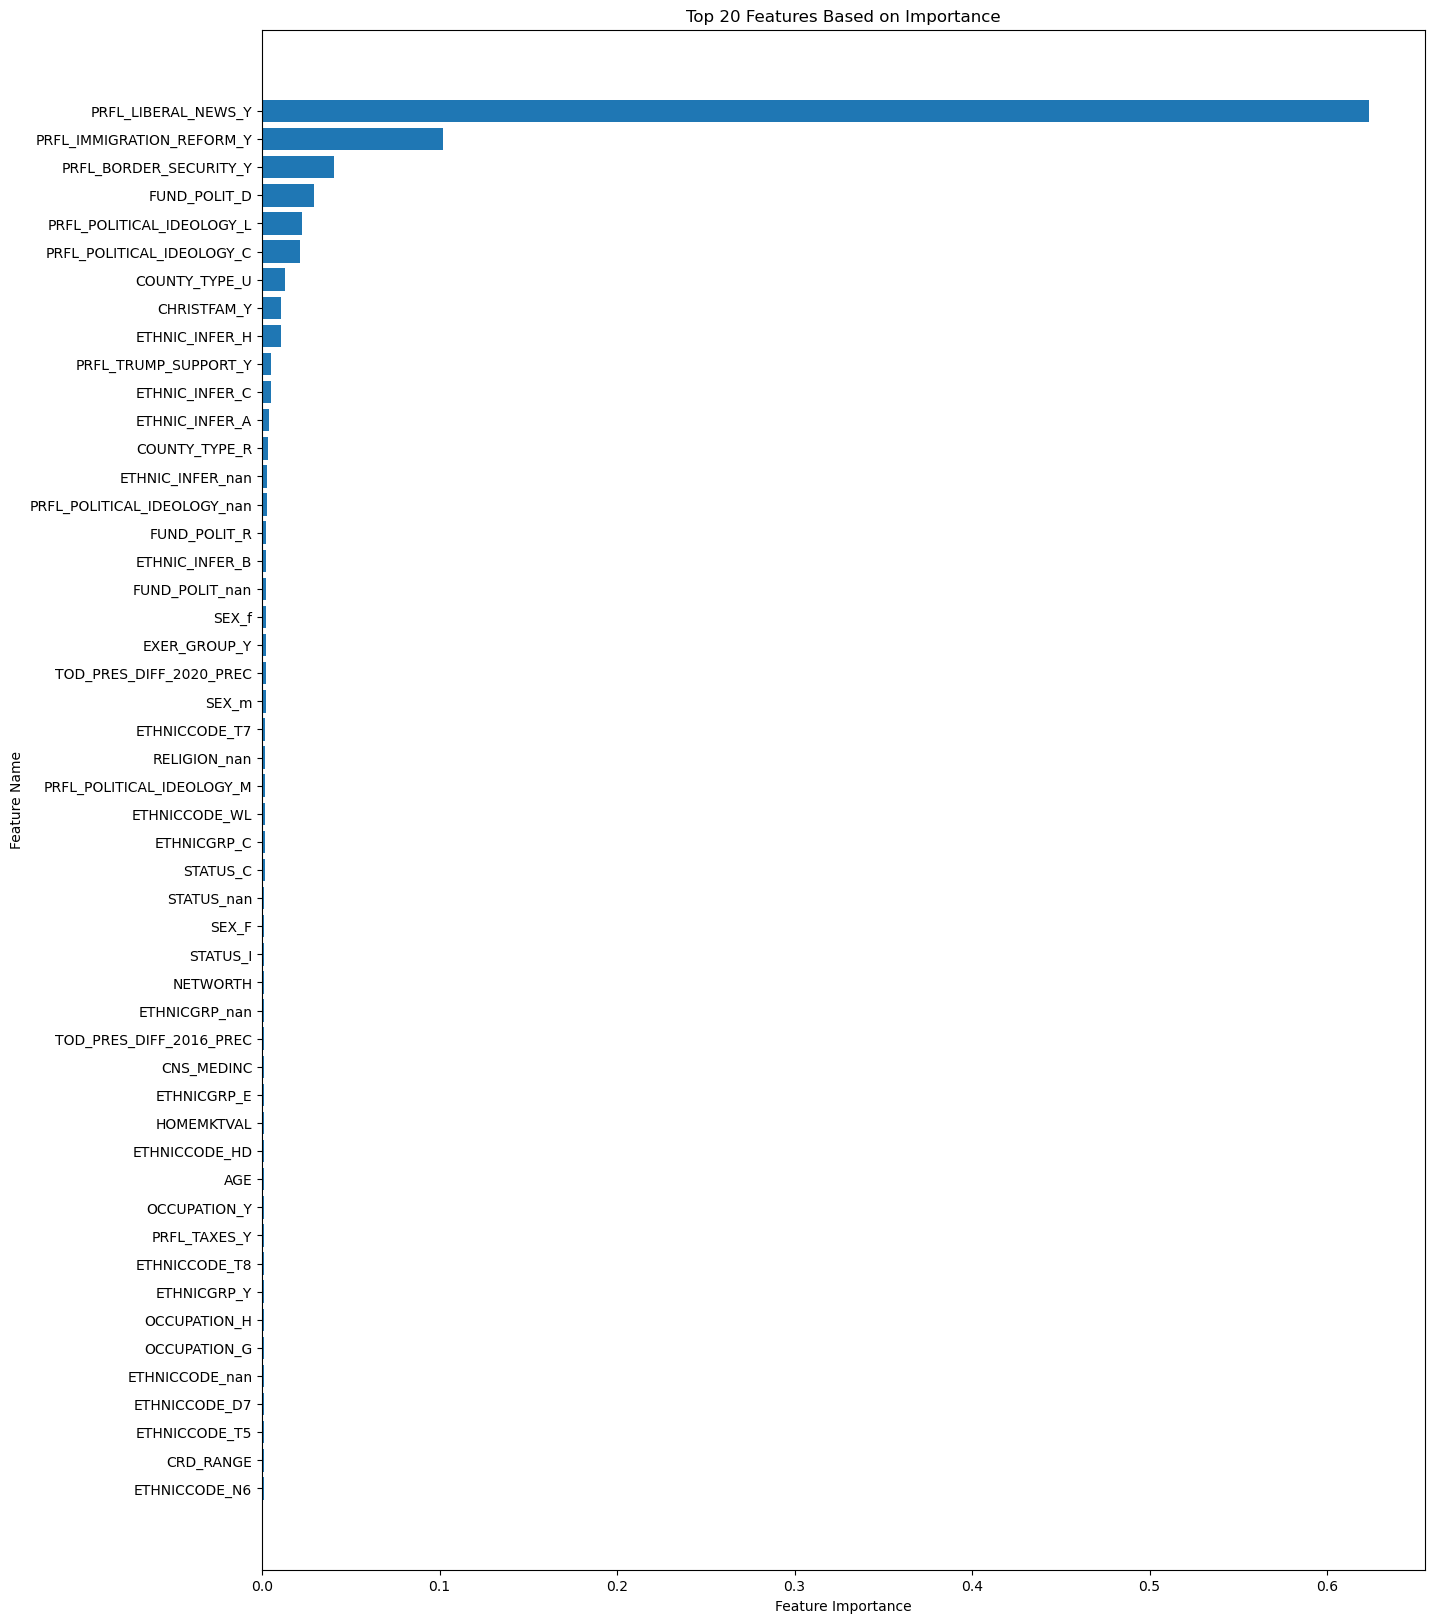

In [1729]:
# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Get the column names for one-hot encoded categorical columns
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
feature_names = np.concatenate([cat_feature_names, numerical_cols])

# Combine importances and column names into a list of tuples
features_list = sorted(zip(feature_importances, feature_names), reverse=True)[:50]

# Separate the tuples for plotting
values, names = zip(*features_list)

# Plot
plt.figure(figsize=(15, 20))
plt.barh(names, values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Features Based on Importance')
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.show()





In [1730]:
# Get the one-hot encoder and its feature names
encoder = preprocessor.named_transformers_['cat']['encoder']
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)

# Combine one-hot-encoded feature names and numerical column names
all_feature_names = np.concatenate([encoded_feature_names, numerical_cols])

# Create a dictionary to store original feature importances
original_feature_importances = dict.fromkeys(X.columns, 0)

for idx, feature_name in enumerate(all_feature_names):
    for original_feature in X.columns:
        if original_feature in feature_name:

            original_feature_importances[original_feature] += feature_importances[idx]
            break

# Sort the features based on importance
sorted_features = sorted(original_feature_importances.items(), key=lambda x: x[1])

# Get the top 20 least useful features
least_useful_features = sorted_features[:50]

print(least_useful_features)

[('AUTOWORK', 0.0008467249572277069), ('PETS', 0.0009063107427209616), ('PRFL_INSURANCE', 0.0009072900866158307), ('HH_SIZE', 0.0009357254020869732), ('INCOMESTHH', 0.0009449833305552602), ('CREDRATE', 0.0009723710245452821), ('YEARBUILT', 0.0009793115314096212), ('LENGTH_RES', 0.0009872191585600376), ('PERSONS_HH', 0.0009921647142618895), ('PRFL_ANML_RIGHTS', 0.0009935435373336077), ('NUMCHILD', 0.0010075971949845552), ('CRD_RANGE', 0.0010171846952289343), ('PRFL_TAXES', 0.0011278296587988734), ('AGE', 0.0011368419509381056), ('HOMEMKTVAL', 0.0011507445015013218), ('CNS_MEDINC', 0.001161618041805923), ('TOD_PRES_DIFF_2016_PREC', 0.0011798772029578686), ('NETWORTH', 0.0012097482103854418), ('TOD_PRES_DIFF_2020_PREC', 0.0021676672622561455), ('EXER_GROUP', 0.002170975087210536), ('GENDER_MIX', 0.003802370047196746), ('PRFL_TRUMP_SUPPORT', 0.005125359632074833), ('STATUS', 0.005489956500241533), ('RELIGION', 0.005504595741513185), ('SEX', 0.006823391478974372), ('ETHNICGRP', 0.0079636054

In [1736]:
features = features + ['Q1_Candidate', 'Q3_Party']
survey_data_features = survey_data[features]
print(survey_data_features.columns)

Index(['CHRISTFAM', 'CRD_RANGE', 'CREDRATE', 'ETHNIC_INFER', 'ETHNICCODE',
       'ETHNICGRP', 'FUND_POLIT', 'INCOMESTHH', 'LENGTH_RES', 'NETWORTH',
       'NUMCHILD', 'PRFL_POLITICAL_IDEOLOGY', 'PRFL_TRUMP_SUPPORT', 'RELIGION',
       'STATUS', 'AGE', 'AUTOWORK', 'CNS_MEDINC', 'COUNTY_TYPE', 'EXER_GROUP',
       'GENDER_MIX', 'HH_SIZE', 'HOMEMKTVAL', 'OCCUPATION', 'PERSONS_HH',
       'PETS', 'PRFL_ANML_RIGHTS', 'PRFL_INSURANCE', 'PRFL_TAXES', 'SEX',
       'YEARBUILT', 'INFER_PARTY', 'TOD_PRES_DIFF_2016_PREC',
       'TOD_PRES_DIFF_2020_PREC', 'PRFL_BORDER_SECURITY',
       'PRFL_IMMIGRATION_REFORM', 'PRFL_LIBERAL_NEWS', 'Q1_Candidate',
       'Q3_Party'],
      dtype='object')


In [1737]:
full_survey = survey_data_features

full_survey['index'] =full_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = full_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)
#X_nan_modeling['INFER_PARTY_PRED'] = gbm_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(full_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

#evaluation_df.loc[evaluation_df['Q1_Candidate']=='President Donald Trump'].head(100)

comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Overall accuracy at predicting whether survey respondents will vote D or R in 2024: {accuracy_percentage:.2f}%")

Overall accuracy at predicting whether survey respondents will vote D or R in 2024: 74.11%


In [1738]:
nan_rows = survey_data_features[survey_data_features['INFER_PARTY'].isna()]

nan_with_survey = nan_rows.copy() 
nan_with_survey['index'] =nan_with_survey.index

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = nan_with_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])

# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

#X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)
X_nan_modeling['INFER_PARTY_PRED'] = gbm_classifier.predict(nan_rows_preprocessed)

evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(nan_with_survey, on='index', how='left')

#evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})
comparison = evaluation_df.copy()


In [1739]:
# comparison.loc[(comparison['target']=='R') & (comparison['PRFL_LIBERAL_NEWS']=='Y')]

In [1740]:
comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Accuracy for 986 voters whose party could not be inferred from 2016-22 voter data: {accuracy_percentage:.2f}%")

Accuracy for 986 voters whose party could not be inferred from 2016-22 voter data: 67.89%


In [1741]:
subset_comparison['target']
percentages = subset_comparison['target'].value_counts(normalize=True) * 100
print(percentages)

target
R    65.714286
D    34.285714
Name: proportion, dtype: float64


In [1742]:
not_nans_survey = survey_data_features.loc[survey_data_features['INFER_PARTY'].isin(['D', 'R'])]
not_nans_survey


,CHRISTFAM,CRD_RANGE,CREDRATE,ETHNIC_INFER,ETHNICCODE,ETHNICGRP,FUND_POLIT,INCOMESTHH,LENGTH_RES,NETWORTH,...,YEARBUILT,INFER_PARTY,TOD_PRES_DIFF_2016_PREC,TOD_PRES_DIFF_2020_PREC,PRFL_BORDER_SECURITY,PRFL_IMMIGRATION_REFORM,PRFL_LIBERAL_NEWS,Q1_Candidate,Q3_Party,index
RECORD_ID,,,,,,,,,,,,,,,,,,,,,
100544,NaN,<NA>,725,C,T6,W,NaN,125000,11,175000,...,<NA>,D,20.0,32.0,NaN,Y,Y,President Joe Biden,Democrat,100544
105000,NaN,4,775,C,UJ,E,NaN,87500,15,75000,...,1930,D,-9.0,-8.0,NaN,Y,Y,Governor Chris Christie,Republican,105000
105817,NaN,<NA>,725,C,NaN,NaN,NaN,125000,15,0,...,<NA>,D,-15.0,-2.0,NaN,Y,Y,President Donald Trump,Republican,105817
1064,NaN,<NA>,725,C,T3,W,D,125000,15,375000,...,<NA>,R,20.0,19.0,Y,NaN,NaN,President Donald Trump,Republican,1064
106884,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,<NA>,D,NaN,NaN,NaN,Y,Y,Governor Ron DeSantis,Republican,106884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,NaN,<NA>,625,C,T6,W,NaN,42500,<NA>,<NA>,...,2001,D,-25.0,-22.0,NaN,Y,Y,President Joe Biden,Democrat,9719
97262,NaN,4,775,C,T3,W,R,125000,15,75000,...,1938,D,-36.0,-34.0,NaN,Y,Y,President Joe Biden,Democrat,97262
99271,NaN,<NA>,725,C,T3,W,NaN,70000,11,375000,...,1940,R,14.0,21.0,NaN,NaN,NaN,President Joe Biden,Unaffiliated/Other,99271


In [1743]:
not_nans_survey = survey_data_features.loc[survey_data_features['INFER_PARTY'].isin(['D', 'R'])]

# List of survey columns to remove
remove_columns = [  'Q2_Support', 'Q4_LikelyVoter', 'Q5_TrumpSupport', 'SURVEY_TYPE']
# Drop the list of columns from the dataset
not_nans_survey.drop(columns=remove_columns, errors='ignore', inplace=True)


not_nans_survey['index'] =not_nans_survey.index



# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = not_nans_survey.drop(columns=['INFER_PARTY','Q1_Candidate','Q3_Party'])


# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)


# # 3. Replace the NaN values in the original large_data dataframe with the predicted values

# # Assuming the index of your nan_rows dataframe corresponds to the index in the original large_data dataframe
# large_data.loc[nan_rows.index, 'INFER_PARTY_pred'] = nan_rows_predictions


evaluation_df = X_nan_modeling[['index', 'INFER_PARTY_PRED']]
evaluation_df = evaluation_df.merge(not_nans_survey, on='index', how='left')

evaluation_df['INFER_PARTY_PRED'] = evaluation_df['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

#evaluation_df.loc[evaluation_df['Q1_Candidate']=='President Donald Trump'].head(100)

comparison = evaluation_df.copy()

comparison = comparison[~comparison['Q1_Candidate'].isin(['Undecided', 'Robert F. Kennedy Jr.'])]

# Create the binary target variable

comparison['target'] = comparison['Q1_Candidate'].apply(lambda x: 'D' if x in ['President Joe Biden','Marianne Williamson'] else 'R')

subset_comparison = comparison[['INFER_PARTY_PRED', 'target']]

correct_predictions = subset_comparison[subset_comparison['INFER_PARTY_PRED'] == subset_comparison['target']].shape[0]
total_predictions = subset_comparison.shape[0]
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Accuracy on 574 voters whose party could be inferred from 2016-2022 voter data: {accuracy_percentage:.2f}%")

Accuracy on 574 voters whose party could be inferred from 2016-2022 voter data: 82.86%


In [1744]:
subset_comparison['target']
percentages = subset_comparison['target'].value_counts(normalize=True) * 100
print(percentages)

target
R    60.828625
D    39.171375
Name: proportion, dtype: float64


In [1745]:
# comparison.loc[(comparison['target']=='R') & (comparison['PRFL_LIBERAL_NEWS']=='Y')]

In [1746]:
full_survey

,CHRISTFAM,CRD_RANGE,CREDRATE,ETHNIC_INFER,ETHNICCODE,ETHNICGRP,FUND_POLIT,INCOMESTHH,LENGTH_RES,NETWORTH,...,YEARBUILT,INFER_PARTY,TOD_PRES_DIFF_2016_PREC,TOD_PRES_DIFF_2020_PREC,PRFL_BORDER_SECURITY,PRFL_IMMIGRATION_REFORM,PRFL_LIBERAL_NEWS,Q1_Candidate,Q3_Party,index
RECORD_ID,,,,,,,,,,,,,,,,,,,,,
100544,NaN,<NA>,725,C,T6,W,NaN,125000,11,175000,...,<NA>,D,20.0,32.0,NaN,Y,Y,President Joe Biden,Democrat,100544
100886,NaN,1,525,C,N6,W,R,87500,15,175000,...,1990,NaN,-25.0,-24.0,Y,NaN,NaN,Undecided,NaN,100886
101569,Y,<NA>,675,C,T3,W,R,87500,15,500000,...,1954,NaN,5.0,NaN,NaN,NaN,Y,President Joe Biden,Democrat,101569
101672,NaN,<NA>,725,C,T7,M,NaN,87500,5,75000,...,2017,NaN,-31.0,-24.0,Y,NaN,NaN,Marianne Williamson,Unaffiliated/Other,101672
101908,NaN,7,725,C,NaN,NaN,NaN,70000,15,175000,...,1961,NaN,1.0,8.0,NaN,NaN,NaN,Robert F. Kennedy Jr.,NaN,101908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99038,NaN,<NA>,<NA>,C,NaN,NaN,NaN,<NA>,<NA>,<NA>,...,<NA>,NaN,8.0,NaN,NaN,Y,Y,President Joe Biden,Democrat,99038
99209,NaN,<NA>,775,C,T5,W,NaN,225000,15,500000,...,<NA>,NaN,48.0,58.0,Y,NaN,NaN,President Donald Trump,Republican,99209
99271,NaN,<NA>,725,C,T3,W,NaN,70000,11,375000,...,1940,R,14.0,21.0,NaN,NaN,NaN,President Joe Biden,Unaffiliated/Other,99271


In [1747]:

# Drop the INFER_PARTY and survey response columns 
X_nan_modeling = full_data.drop(columns=['INFER_PARTY'])


# Convert categorical columns to string type
X_nan_modeling[categorical_cols] = X_nan_modeling[categorical_cols].astype(str)

# Apply the preprocessor
nan_rows_preprocessed = preprocessor.transform(X_nan_modeling)

# 2. Use the trained Gradient Boosting model to make predictions on the nan_rows dataframe

X_nan_modeling['INFER_PARTY_PRED'] = xgb_classifier.predict(nan_rows_preprocessed)
X_nan_modeling['INFER_PARTY_PRED'] = X_nan_modeling['INFER_PARTY_PRED'].map({0: 'D', 1: 'R'})

X_nan_modeling



,ADD_TYPE,AFAMPROFLS,AGE,AIRCOND,APP_CHILD,APP_MENBIG,APP_TODDLR,APP_WOMEN,APP_WOMPET,APP_WOMPLS,...,WORKWOMAN,YEARBUILT,ZIP,interaction_div_2020,interaction_div_2016,interaction_mult_delta,interaction_div_D_2020,interaction_div_D_2016,interaction_mult_D_delta,INFER_PARTY_PRED
RECORD_ID,,,,,,,,,,,,,,,,,,,,,
403390,S,NaN,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99705,0.914355,0.928793,84.705882,0.000000,0.000000,0.000000,D
62285,H,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99506,0.773994,0.744786,-113.684210,0.084890,0.110571,18.947369,D
331355,NaN,NaN,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99603,NaN,NaN,NaN,NaN,NaN,NaN,D
206320,H,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,99567,1.047534,0.999232,-221.909549,0.000000,0.000000,0.000000,R
188078,S,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Y,1985,99801,1.806932,1.799041,-16.479218,0.000000,0.000000,0.000000,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349635,H,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,31204,0.643382,0.764415,14.669117,1.032289,1.014772,-134.558823,D
420654,S,NaN,50,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2003,30263,1.266285,1.222340,-256.764705,0.000000,0.000000,0.000000,D
131262,S,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,<NA>,30013,1.041124,0.804505,-127.433628,0.811798,0.892185,454.184579,D


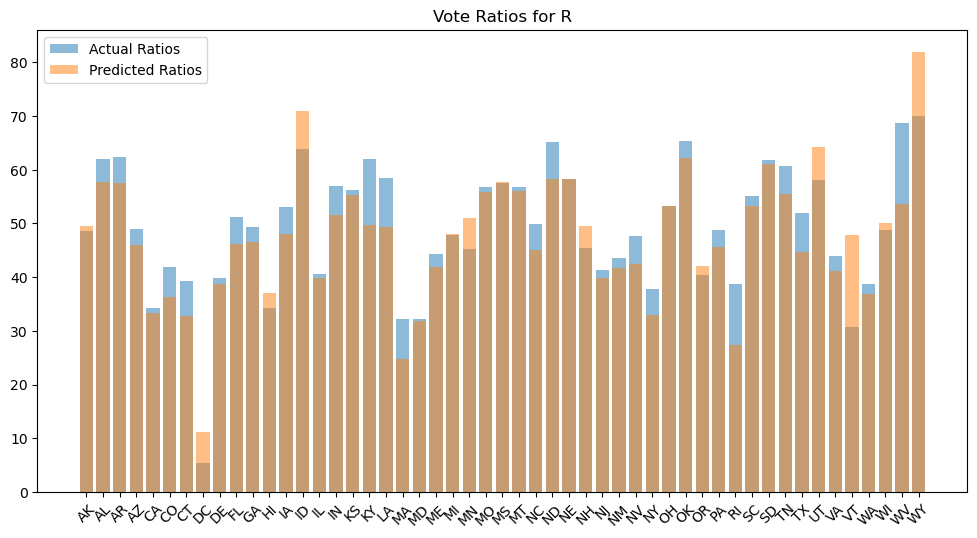

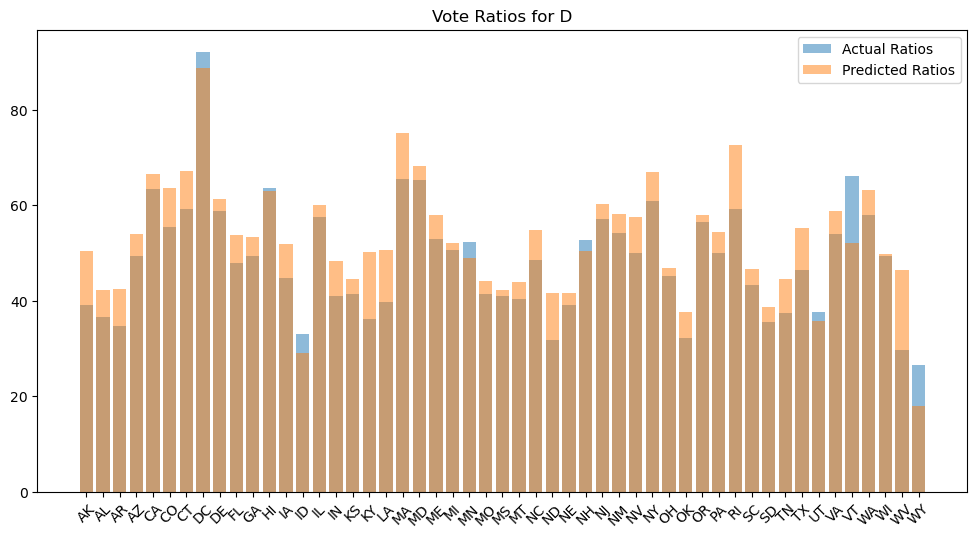

In [1750]:
votes_by_state_df = pd.read_csv('data/VOTES_BY_STATE_2020_PRES.csv')
votes_by_state_df['Total_Votes'] = votes_by_state_df[['VOTES_TRUMP', 'VOTES_BIDEN', 'VOTES_OTHER']].sum(axis=1)
votes_by_state_df['R'] = votes_by_state_df['VOTES_TRUMP'] / votes_by_state_df['Total_Votes'] * 100
votes_by_state_df['D'] = votes_by_state_df['VOTES_BIDEN'] / votes_by_state_df['Total_Votes'] * 100
actual_ratios_df = votes_by_state_df[['STATE', 'R', 'D']]

# Count the number of 'D' and 'R' predictions by state
party_counts = X_nan_modeling.groupby(['STATE', 'INFER_PARTY_PRED']).size().reset_index(name='count')

# Convert these counts into percentages
total_counts = party_counts.groupby('STATE')['count'].transform('sum')
party_counts['Percentage'] = (party_counts['count'] / total_counts) * 100


# Pivot the data for easier merging and visualization
statewise_percentages = party_counts.pivot(index='STATE', columns='INFER_PARTY_PRED', values='Percentage').reset_index()

# Now you can merge this with actual_ratios_df as previously explained:

comparison_df = pd.merge(actual_ratios_df, statewise_percentages, on='STATE', how='inner')

# Visualization
import matplotlib.pyplot as plt

parties = ['R', 'D']
for party in parties:
    plt.figure(figsize=(12, 6))
    plt.bar(comparison_df['STATE'], comparison_df[party+'_x'], alpha=0.5, label='Actual Ratios')
    plt.bar(comparison_df['STATE'], comparison_df[party+'_y'], alpha=0.5, label='Predicted Ratios')
    plt.title(f'Vote Ratios for {party}')
    plt.xticks(rotation=45)  
    plt.legend()
    plt.show()



In [ ]:
# engineered_data = corrected_data.copy()
# voter_columns = [col for col in engineered_data.columns if col.startswith("VTR")]
# #Create column with total number of votes in voter_columns per row
# engineered_data['VTR_TOTAL_VOTES'] = engineered_data[voter_columns].notnull().sum(axis=1)
# #Sum Democrat and Republican totals
# engineered_data['VTR_TOTAL_DVOTES'] = engineered_data[voter_columns].isin(['D', 'M', 'Z']).sum(axis=1)
# engineered_data['VTR_TOTAL_RVOTES'] = engineered_data[voter_columns].isin(['R', 'P', 'X']).sum(axis=1)
# #Create conditions that evaluate whether more votes have been cast for Democrats or Republicans, and assign 'D' and 'R' to new column based on conditions
# conditions = [
#     engineered_data['VTR_TOTAL_DVOTES'] > engineered_data['VTR_TOTAL_RVOTES'],
#     engineered_data['VTR_TOTAL_DVOTES'] < engineered_data['VTR_TOTAL_RVOTES']
# ]
# choices = ['D', 'R']
# engineered_data['VTR_INFER_PARTY'] = np.select(conditions, choices, default=np.nan)
# #Create conditions that evaluate whether a voter is a swing voter or not
# conditions_swing = [
#     (engineered_data['VTR_TOTAL_DVOTES'] > 2) & (engineered_data['VTR_TOTAL_RVOTES'] > 2),
#     ((engineered_data['VTR_TOTAL_DVOTES'] > 1) & (engineered_data['VTR_TOTAL_RVOTES'] == 0)) | ((engineered_data['VTR_TOTAL_RVOTES'] > 1) & (engineered_data['VTR_TOTAL_DVOTES'] == 0))
# ]
# choices_swing = ['Y', 'N']
# engineered_data['VTR_INFER_SWING'] = np.select(conditions_swing, choices_swing, default=np.nan)
# #sampledf = engineered_data[['PARTY_CODE','INFER_PARTY','VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY','VTR_INFER_SWING']]
# #print(sampledf.head(50))
# #Add values to INFER_PARTY and correct any other INFER_PARTY values that don't meet the conditions above:
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'D'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'N'), 'INFER_PARTY'] = 'R'
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'D') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# engineered_data.loc[(engineered_data['VTR_INFER_PARTY'] == 'R') & (engineered_data['VTR_INFER_SWING'] == 'Y'), 'INFER_PARTY'] =  float('nan')
# #Also delete any 'D' or 'R' INFER_PARTY labels for anyone deemed a "swing voter" based on criteria above of voting for both parties at least 3 times each:
# engineered_data.loc[(engineered_data['VTR_INFER_SWING'] == 'Y') , 'INFER_PARTY'] = float('nan')
# print(sum(engineered_data['INFER_PARTY'].isna())) #291 NaNs for INFER_PARTY before
# #Drop auxiliary columns used for math, keeping 'VTR_TOTAL_VOTES', 'VTR_INFER_SWING', and the updated 'INFER_PARTY' columns as features:
# engineered_data = engineered_data.drop(columns=['VTR_TOTAL_DVOTES','VTR_TOTAL_RVOTES','VTR_INFER_PARTY'])
# # Drop the list of columns from the dataset
# #engineered_data_cleaned = engineered_data.drop(columns=remove_columns, errors='ignore')
# 
# # features_to_remove = [
# #     'PRFL_CHOICELIFE', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_O_2016',
# #     'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC', 'TOD_PRES_R_2020_PREC', 'VP_PPP',
# #     'AGE', 'CNSUS_PCTW'
# # ]
# # # Assuming 'engineered_data' is your DataFrame, remove the less important features
# # engineered_data = engineered_data.drop(columns=features_to_remove, errors='ignore')
